In [1]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


PARQA= os.getenv('PARQA')

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def getAllFiles(path, frmt=None, full=False):
    '''return all files in the folder,
    filtered by format, if it was provided'''
    
    fs = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        if frmt!=None:
            fsTmp = [fl for fl in filenames if fl.endswith(frmt)]
            fs.extend(fsTmp)
        else:
            fsTmp = filenames
            fs.extend(fsTmp)
    if full:
        return [path+f for f in fs]
    else:
        return fs
    

In [3]:
path = PARQA + 'data/RAW/raw_311_download/'
df = pd.concat((pd.read_csv(x) for x in getAllFiles(path,'.csv', full=True))).drop_duplicates()

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (8,13,14,17,18,20,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (8,39,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (8,17,39,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (8,17,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/

In [4]:
df.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [5]:
df['Created Date'].head(2)

0    12/31/2010 11:59:12 PM
1    12/31/2010 11:57:30 PM
Name: Created Date, dtype: object

In [5]:
df['Created Date'] = pd.to_datetime(df['Created Date'])

In [7]:
dpr =pd.DataFrame(df['Created Date'][df.Agency=='DPR'])
dpr['N'] = 1
dpr = dpr.set_index('Created Date').resample('1M', how='sum')

In [8]:
total =pd.DataFrame(df['Created Date'])
total['N'] = 1
total = total.set_index('Created Date').resample('1M', how='sum')

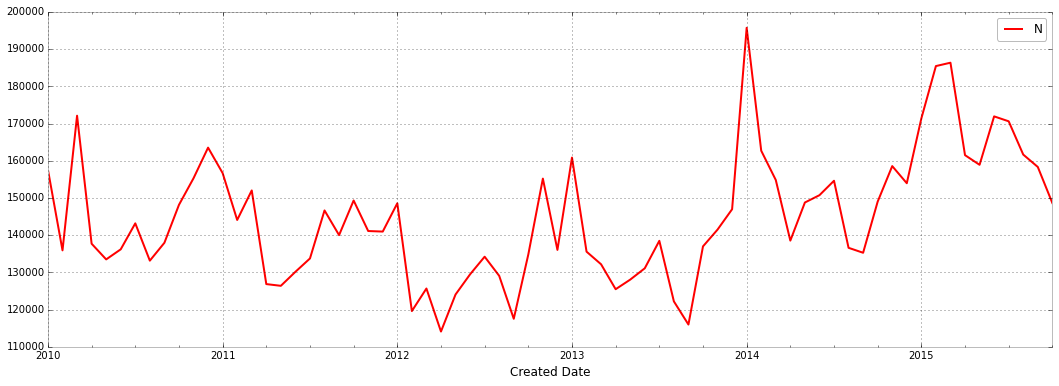

In [21]:
fig,ax = plt.subplots(figsize=(18,6))
total.plot(ax=ax, label='total', c='r', legend=0)
# dpr.plot(ax=ax, label='DPR')
# plt.legend()

plt.savefig(PARQA + 'parqa/311/img/exploration1.png')

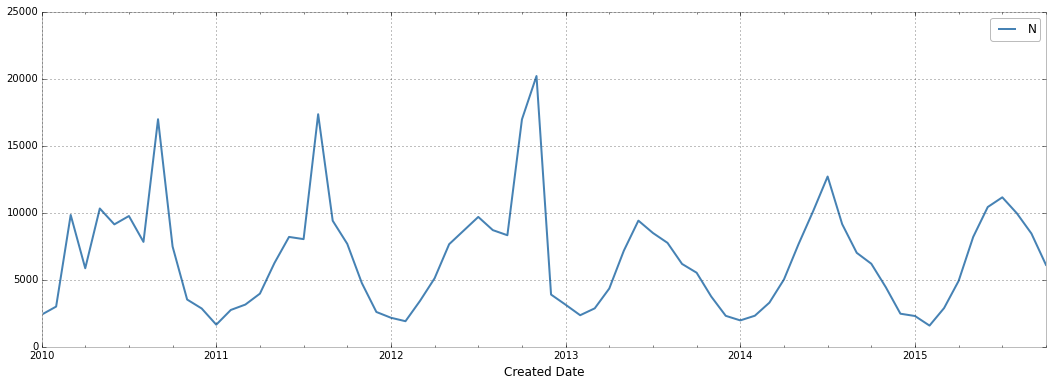

In [22]:
fig,ax = plt.subplots(figsize=(18,6))
dpr.plot(ax=ax, label='DPR')
# plt.legend()

plt.savefig(PARQA + 'parqa/311/img/exploration2.png')

In [17]:
len(df[df.Agency=='DPR'])

463533

In [16]:
len(df)

10140668

BRONX
BROOKLYN
MANHATTAN
QUEENS
STATEN ISLAND
Unspecified


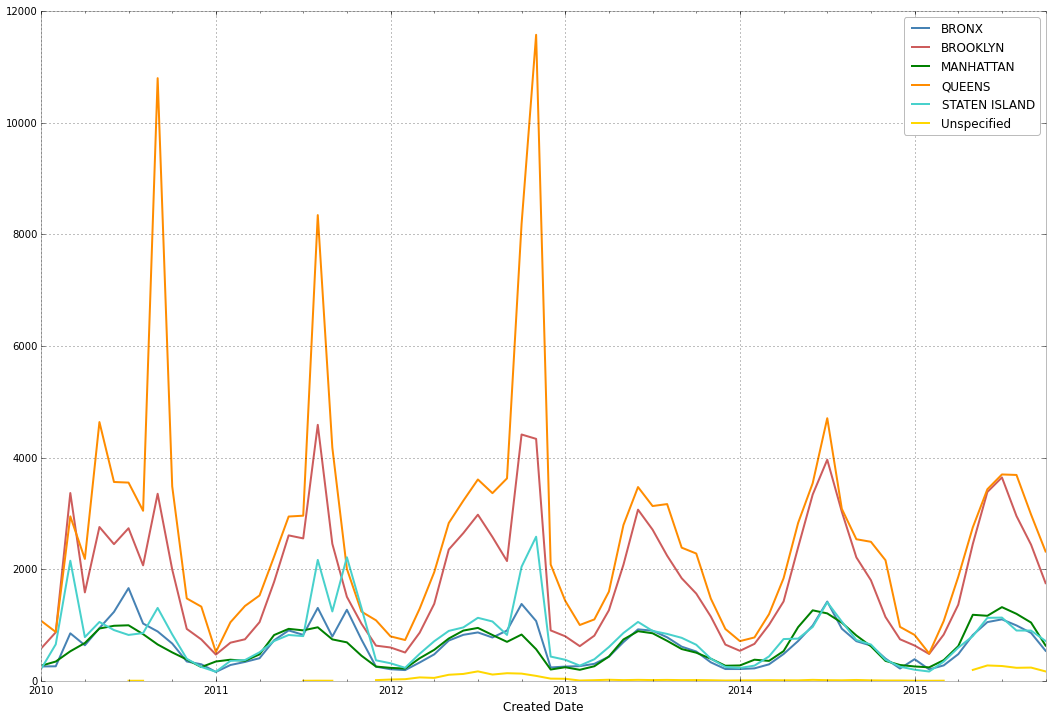

In [30]:
dprB =pd.DataFrame(df[['Created Date','Park Borough']][df.Agency=='DPR'])
dprB['N'] = 1

fig, ax = plt.subplots(figsize=(18, 12))



for name, g in dprB.groupby('Park Borough'):
    print name
    g = g.set_index('Created Date').resample('1M', how='sum')
    g.plot(ax=ax, label='name')
    
plt.legend(('BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND','Unspecified'))
plt.savefig(PARQA + 'parqa/311/img/exploration3.png')

In [8]:
DPR = df[df.Agency=='DPR']

In [9]:
DPR.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',